İterasyon:0 Maliyet: 11337.620273
İterasyon:10 Maliyet: 10665.502005
İterasyon:20 Maliyet: 10355.957467
İterasyon:30 Maliyet: 10210.955371
İterasyon:40 Maliyet: 10142.556985
İterasyon:50 Maliyet: 10110.549335
İterasyon:60 Maliyet: 10096.116267
İterasyon:70 Maliyet: 10090.324871
İterasyon:80 Maliyet: 10088.882554
İterasyon:90 Maliyet: 10089.697633
İterasyon:100 Maliyet: 10091.731131
İterasyon:110 Maliyet: 10152.499737
İterasyon:120 Maliyet: 10097.064355
İterasyon:130 Maliyet: 10077.029870
İterasyon:140 Maliyet: 10074.582937


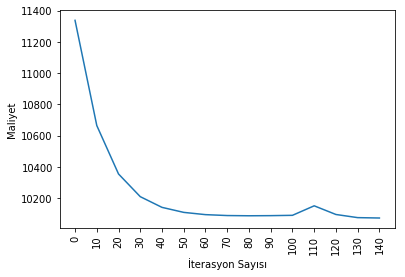

train doğruluğu:57.861635220125784 %
test doğruluğu:52.5 %


In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sys
from sklearn.preprocessing import Imputer
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
import warnings
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
# Sürümden kaynaklı hatalı göz ardı etmek için kullanıyoruz.
warnings.filterwarnings('ignore')


data=pd.read_csv('Atrain2.csv')


# verileri x input ve y output olarak ayırıyoruz
 
y = data["ACTION"].values.reshape(-1,1)  #sütun haline getirdik
x = data.drop(["ACTION","MGR_ID","RESOURCE"],axis=1)

#datayı eğitmek ve test için sklearn kutuphanesini kullanarak %80 train,%20 test olarak ayırıyoruz
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42,shuffle=True)



# elde ettiğimiz verilerin transposunu alıyoruz
# backward ve predict işlemleri yaparken matrix hatasını gidermek için bunu yaptık, forward ı buna göre yeniledik 
x_train = X_train.T
y_train = Y_train.T
x_test = X_test.T
y_test = Y_test.T


#KULLANACAĞIMIZ AKTİVASYON FONKSİYONLARI
def tanh(z):
    return np.tanh(z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))



def initialize_weights_and_bias(inputs,layer_size,outputs):
    parameters = {"weight1": np.random.randn(layer_size,inputs.shape[0]) * 0.01,
                  "bias1": np.zeros((layer_size,1)),
                  "weight2": np.random.randn(outputs.shape[0],layer_size) * 0.01,
                  "bias2": np.zeros((outputs.shape[0],1))
                 }
    return parameters

def forward_propagation(x_train,parameters):
    z1=np.dot(parameters["weight1"],x_train)+parameters["bias1"] #inputlar ile weight leri çarpıp biası toplayarak z1'ibulduk.
    a1=np.tanh(z1) #tangent activation funcito kullanılarak #hidden layer
    z2=np.dot(parameters["weight2"],a1)+parameters["bias2"]
    a2=sigmoid(z2) #binary classification yapmak için sigmoid kullandık (0/1 arasında sıkıştırıyor) #output layer 
    cache={"z1":z1,
          "a1":a1,
          "z2":z2,
          "a2":a2
          } #update de kullanmak için bunları cache'e atıyoruz

    return a2,cache

#maliyet hesabı
def computeCost(a2,y):
    loss=np.multiply(np.log(a2),y)
    cost=-np.sum(loss)/y.shape[1]
    return cost

def backward_propagation(parameters,cache,x,y):
    dz2=cache["a2"]-y
    dw2=np.dot(dz2,cache["a1"].T)/x.shape[1]
    db2=np.sum(dz2,axis=1,keepdims=True)/x.shape[1]
    dz1=np.dot(parameters["weight2"].T,dz2)*(1-np.power(cache["a1"],2))
    dw1=np.dot(dz1,x.T)/x.shape[1]
    db1=np.sum(dz1,axis=1,keepdims=True)/x.shape[1]
    grads={
        "dweight1":dw1,
        "dbias1":db1,
        "dweight2":dw2,
        "dbias2":db2
    }
    return grads

def update_parameters(parameters,grads,learning_rate=0.03):
    parameters={
        "weight1":parameters["weight1"]-learning_rate*grads["dweight1"],
        "bias1":parameters["bias1"]-learning_rate*grads["dbias1"],
        "weight2":parameters["weight2"]-learning_rate*grads["dweight2"],
        "bias2":parameters["bias2"]-learning_rate*grads["dbias2"],
    }
    return parameters



def prediction(parameters,x_test):
    
    a2,cache =forward_propagation(x_test,parameters)
    y_prediction=np.zeros((1,x_test.shape[1]))
  
    for i in range(cache["a2"].shape[1]):
        if cache["a2"][0,i] > 0.5:
            y_prediction[0,i]=1
        else:
            y_prediction[0,i]=0
            
            
    return y_prediction

def ikiKatmanlıYsa(x_train,y_train,x_test,y_test,iteration,hidden_layer_size):
    costList=[]
    indexList=[]
    parameters=initialize_weights_and_bias(x_train,hidden_layer_size,y_train)
    
    for i in range(0,iteration):
        #ileri-besleme
        a2,cache=forward_propagation(x_train,parameters)
        #maliyet hesabı
        cost=computeCost(a2,y)
        #geri-besleme
        grads=backward_propagation(parameters,cache,x_train,y_train)
        #update parameters
        parameters=update_parameters(parameters,grads)
        
        
        if i % 10==0:
            costList.append(cost)
            indexList.append(i)
            print("İterasyon:%i Maliyet: %f"%(i,cost))
            
    plt.plot(indexList,costList)
    plt.xticks(indexList,rotation='vertical')
    plt.xlabel("İterasyon Sayısı")
    plt.ylabel("Maliyet")
    plt.show()
    
    #tahmin 
    y_tahmin_test=prediction(parameters,x_test)
    y_tahmin_train=prediction(parameters,x_train)
    
    #Train/test hatalarını yazma
    print("train doğruluğu:{} %".format(100-np.mean(np.abs(y_tahmin_train-y_train))*100))
    print("test doğruluğu:{} %".format(100-np.mean(np.abs(y_tahmin_test-y_test))*100))
    return parameters,y_tahmin_test
   
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, [0,1])
    plt.yticks(tick_marks, [0,1])
    plt.tight_layout()
    plt.ylabel('Beklenen Değer')
    plt.xlabel('Tahmin Edilen Değer')


    
            



parameters,y_tahmin_test=ikiKatmanlıYsa(x_train,y_train,x_test,y_test,iteration=150,hidden_layer_size=13)




[[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


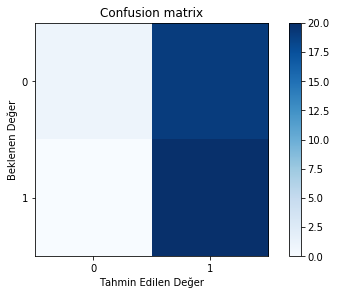

In [126]:
print(y_tahmin_test)
result =confusion_matrix(np.squeeze(y_test),np.squeeze(y_tahmin_test))
plot_confusion_matrix(result)



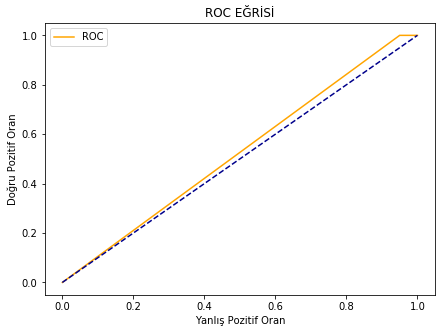

Doğruluk  0.525


In [127]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr, auc_score):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Yanlış Pozitif Oran')
    plt.ylabel('Doğru Pozitif Oran')
    plt.title('ROC EĞRİSİ'.format(auc_score))
    plt.legend()
    plt.show()
    
     
a=np.squeeze(y_test)
b=np.squeeze(y_tahmin_test)
auc_score = roc_auc_score(a,b)
fpr, tpr, thresholds = roc_curve(a,b)
plt.figure(figsize=(7, 5))
plot_roc_curve(fpr, tpr, auc_score)
plt.show()
print("Doğruluk ",auc_score)